In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

from keras import models
from keras import layers


Using TensorFlow backend.


In [2]:
header=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
'''
1) CRIM per capita crime rate by town
2) ZN proportion of residential land zoned for lots over25,000 sq.ft.
3) INDUS proportion of non-retail business acres per town
4) CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5) NOX nitric oxides concentration (parts per 10 million)
6) RM average number of rooms per dwelling
7) AGE proportion of owner-occupied units built prior to 1940
8) DIS weighted distances to five Boston employment centres
9) RAD index of accessibility to radial highways
10) TAX full-value property-tax rate per $10,000
11) PTRATIO pupil-teacher ratio by town
12) B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13) LSTAT % lower status of the population
14) MEDV Median value of owner-occupied homes in $1000's '''

"\n1) CRIM per capita crime rate by town\n2) ZN proportion of residential land zoned for lots over25,000 sq.ft.\n3) INDUS proportion of non-retail business acres per town\n4) CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)\n5) NOX nitric oxides concentration (parts per 10 million)\n6) RM average number of rooms per dwelling\n7) AGE proportion of owner-occupied units built prior to 1940\n8) DIS weighted distances to five Boston employment centres\n9) RAD index of accessibility to radial highways\n10) TAX full-value property-tax rate per $10,000\n11) PTRATIO pupil-teacher ratio by town\n12) B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town\n13) LSTAT % lower status of the population\n14) MEDV Median value of owner-occupied homes in $1000's "

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
data = pd.read_csv(url, sep='\s+', header = None)
data.columns=header

# 데이터 전처리 및 속성별 확인 과정

In [5]:
dup_data=data.drop_duplicates() #중복행 확인
# dup_data

In [4]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


<function matplotlib.pyplot.show(*args, **kw)>

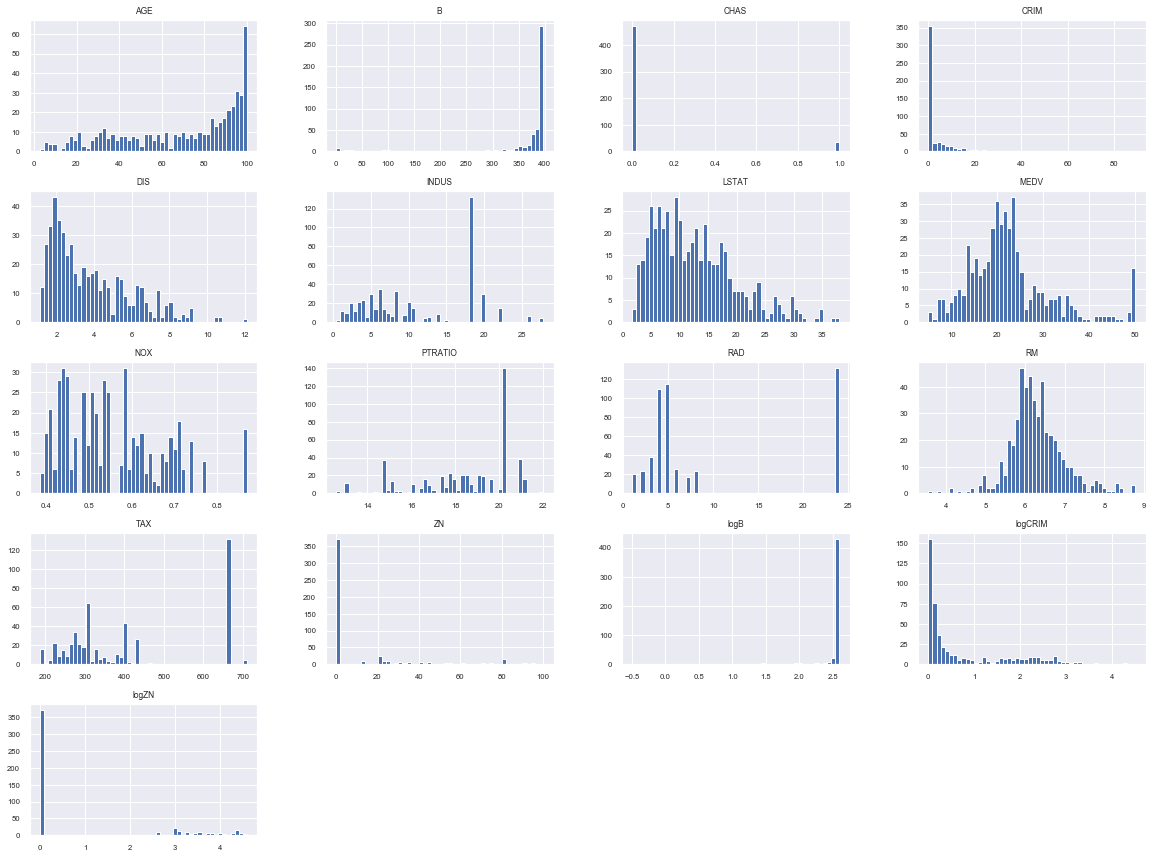

In [18]:
# 수치형 데이터 탐색
data.hist(bins=50,figsize=(20,15))
plt.show
# x축은 값,y축은 number of sample

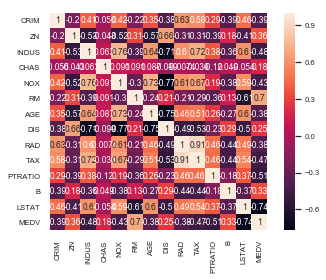

In [19]:
corr=np.corrcoef(data[header].values.T)
sns.set(font_scale=0.7)
hm=sns.heatmap(corr,cbar=True,square=True,annot=True,yticklabels=header,xticklabels=header)

In [20]:
# 'CHAS,'B','CRIM,'ZN'은 전처리가 필요함 
# CHAS는 전 데이터와 상관계수가 낮아서 삭제
# ZN, B,CRIM은 로그,지수변환으로 가우시안화
data['logB']=np.log10(data['B'])
data['logZN']=np.log1p(data['ZN'])
data['logCRIM']=np.log1p(data['CRIM'])

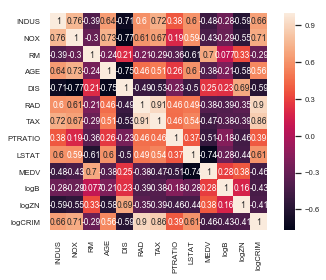

In [21]:
''' abs(0.7)이상의 상관계수를 보이는 col끼리 묶으면,
1st= RM,LSTAT,MEDV
2nd= INDUS,NOX,DIS,AGE
3nd= RAD,TAX,logCRIM
가 된다.  
'''
# logCRIM은 RAD,TAX와 높은 상관관계를 보여 3rd그룹에 속함
#0.7 이상의 상관계수를 지니는 컬럼끼리는 다중공선성이라 가정하고 make new feature
header3=['INDUS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','LSTAT','MEDV','logB','logZN','logCRIM']
corr=np.corrcoef(data[header3].values.T)
sns.set(font_scale=0.7)
hm=sns.heatmap(corr,cbar=True,square=True,annot=True,yticklabels=header3,xticklabels=header3)

In [23]:
# 데이터 분할 and column 삭제 
train_set,test_set = train_test_split(data,test_size=0.3,random_state=42)


In [52]:
X_train_set=train_set.drop(['CRIM','ZN','PTRATIO','B','logB','CHAS','MEDV'],1)
y_train_set=train_set['MEDV']
X_test_set=test_set.drop(['CRIM','ZN','PTRATIO','B','logB','CHAS','MEDV'],1)
y_test_set=test_set['MEDV']

# 데이터 모델링

## 1. 머신러닝 모델 

In [53]:
# 하이퍼파라미터 설정   
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [54]:
# 모델 학습함수
def cv_mae(model, X=X_train_set):
    mae = -cross_val_score(model, X_train_set, y_train_set,
                                    scoring="neg_mean_absolute_error",
                                    cv=kfolds)
    pred = model.fit(X_train_set, y_train_set)
    y_predicted = model.predict(X=X_test_set)
    mae_test= np.mean(np.abs(y_predicted - y_test_set))
    return mae,mae_test

In [55]:
# 선형회귀기반 모델 
ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds,))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, random_state=42, l1_ratio=e_l1ratio))
                                        
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


In [ ]:
# 트리기반 모델
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
                                   

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )

## 2. 딥러닝 모델

In [56]:
def build_model():
    model=models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(X_train_set.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])
    return model

In [64]:
deep_pre_time=datetime.now()

k = 4
num_val_samples = len(X_train_set) // k
num_epochs = 400
all_mse_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = X_train_set[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train_set[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate([X_train_set[:i * num_val_samples],X_train_set[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([y_train_set[:i * num_val_samples],y_train_set[(i + 1) * num_val_samples:]],axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=10, verbose=0)
    mse_history = history.history['val_mean_absolute_error']
    all_mse_histories.append(mse_history)
    
deep_pre_time=datetime.now()-deep_pre_time

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


# 데이터 Evaluation

In [58]:
pre_time=datetime.now()
mae,mae_test = cv_mae(ridge)
print("Kernel Ridge score: mean:{:.4f} (std:{:.4f})\n runntime:".format(mae.mean(), mae.std()), datetime.now()-pre_time, )
print("Kernel Ridge pred-score:",mae_test,"\n" )
      
pre_time=datetime.now()
mae,mae_test = cv_mae(lasso)
print("Lasso score: mean:{:.4f} (std:{:.4f})\n runntime".format(mae.mean(), mae.std()), datetime.now()-pre_time, )
print("Lasso pred-score:",mae_test,"\n")
      
      
pre_time=datetime.now()
mae,mae_test = cv_mae(elasticnet)
print("ElasticNet score: mean:{:.4f} (std:{:.4f})\n runntime".format(mae.mean(), mae.std()), datetime.now()-pre_time, )
print("ElasticNet pred-score: ",mae_test,"\n")
      
pre_time=datetime.now()
mae,mae_test = cv_mae(svr)
print("SVR score: mean:{:.4f} (std:{:.4f})\n runntime".format(mae.mean(), mae.std()), datetime.now()-pre_time, )
print("SVR pred-score:",mae_test,"\n" )
      
pre_time=datetime.now()
mae,mae_test = cv_mae(lightgbm)
print("Lightgbm score: mean:{:.4f} (std:{:.4f})\n runntime".format(mae.mean(), mae.std()), datetime.now()-pre_time, )
print("Lightgbm pred-score:",mae_test,"\n" )
      
pre_time=datetime.now()
mae,mae_test = cv_mae(gbr)
print("GradientBoosting score: mean:{:.4f} (std:{:.4f})\n runntime".format(mae.mean(), mae.std()), datetime.now()-pre_time, )
print("GradientBoosting pred-score:",mae_test,"\n" )

C:\Users\taehee\Anaconda3\envs\tf_keras\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\taehee\Anaconda3\envs\tf_keras\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\taehee\Anaconda3\envs\tf_keras\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\taehee\Anaconda3\envs\tf_keras\lib\site-

Kernel Ridge score: mean:3.8039 (std:0.7116)
 runntime: 0:00:02.674846
Kernel Ridge pred-score: 3.6728388835300754 

Lasso score: mean:3.8559 (std:0.6362)
 runntime 0:00:00.259306
Lasso pred-score: 3.6199544948396616 

ElasticNet score: mean:3.8550 (std:0.6364)
 runntime 0:00:00.955445
ElasticNet pred-score:  3.620307935536951 

SVR score: mean:4.9106 (std:0.8900)
 runntime 0:00:00.120677
SVR pred-score: 4.289586755783465 

Lightgbm score: mean:2.7052 (std:0.4196)
 runntime 0:00:07.384253
Lightgbm pred-score: 2.351534105024359 

GradientBoosting score: mean:2.3410 (std:0.2990)
 runntime 0:00:39.537265
GradientBoosting pred-score: 1.9887824523369608 



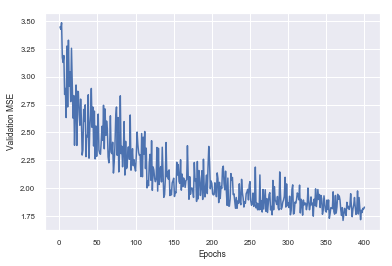

Deep learning pred-score: 1.9012332918434056


In [59]:
average_mae_history = [
    np.sqrt(np.mean([x[i] for x in all_mse_histories])) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mse_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MSE')
plt.show()
print("Deep learning score:",np.mean(average_mae_history[150:]))

In [65]:
test_mse_score,test_mae_score = model.evaluate(X_test_set, y_test_set)
print("runntime:",deep_pre_time)
print("Deep learning pred-score:",np.sqrt(test_mae_score))

152/152 [==============================] - 0s 52us/step
runntime: 0:00:39.512332
Deep learning pred-score: 1.6425721776997733
